In [5]:
#Importing necessary libraries for data extract, visualization, and model testing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

#import warnings
#warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv('C:/Users/mcthu/Code Projects/Machine_Learning/google-stock-price-prediction/GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512


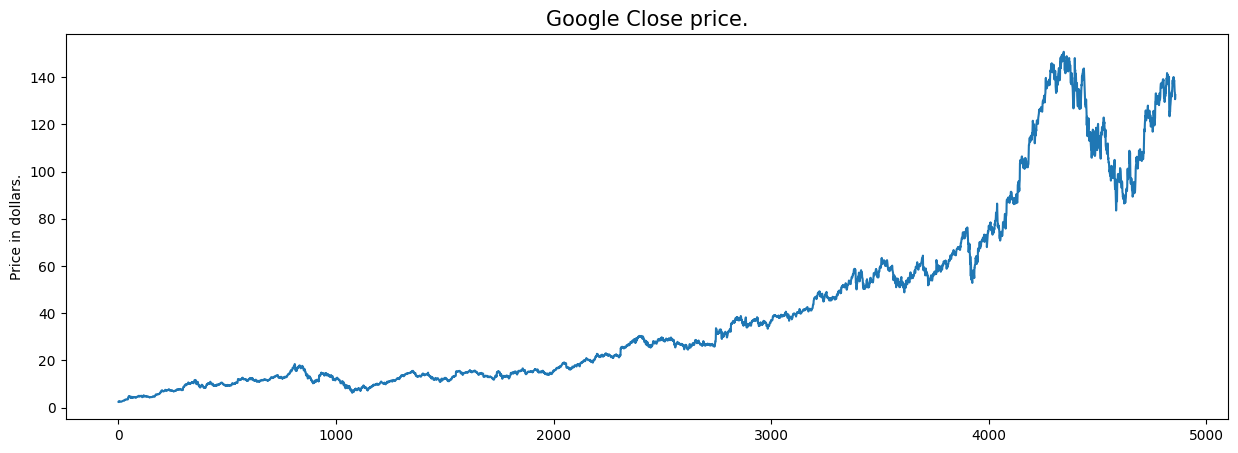

In [8]:
#Basic Data Visualization to gather general idea of data
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Google Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [10]:
df[df['Close'] == df['Adj Close']].shape
df = df.drop(['Adj Close'], axis=1)
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [14]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']



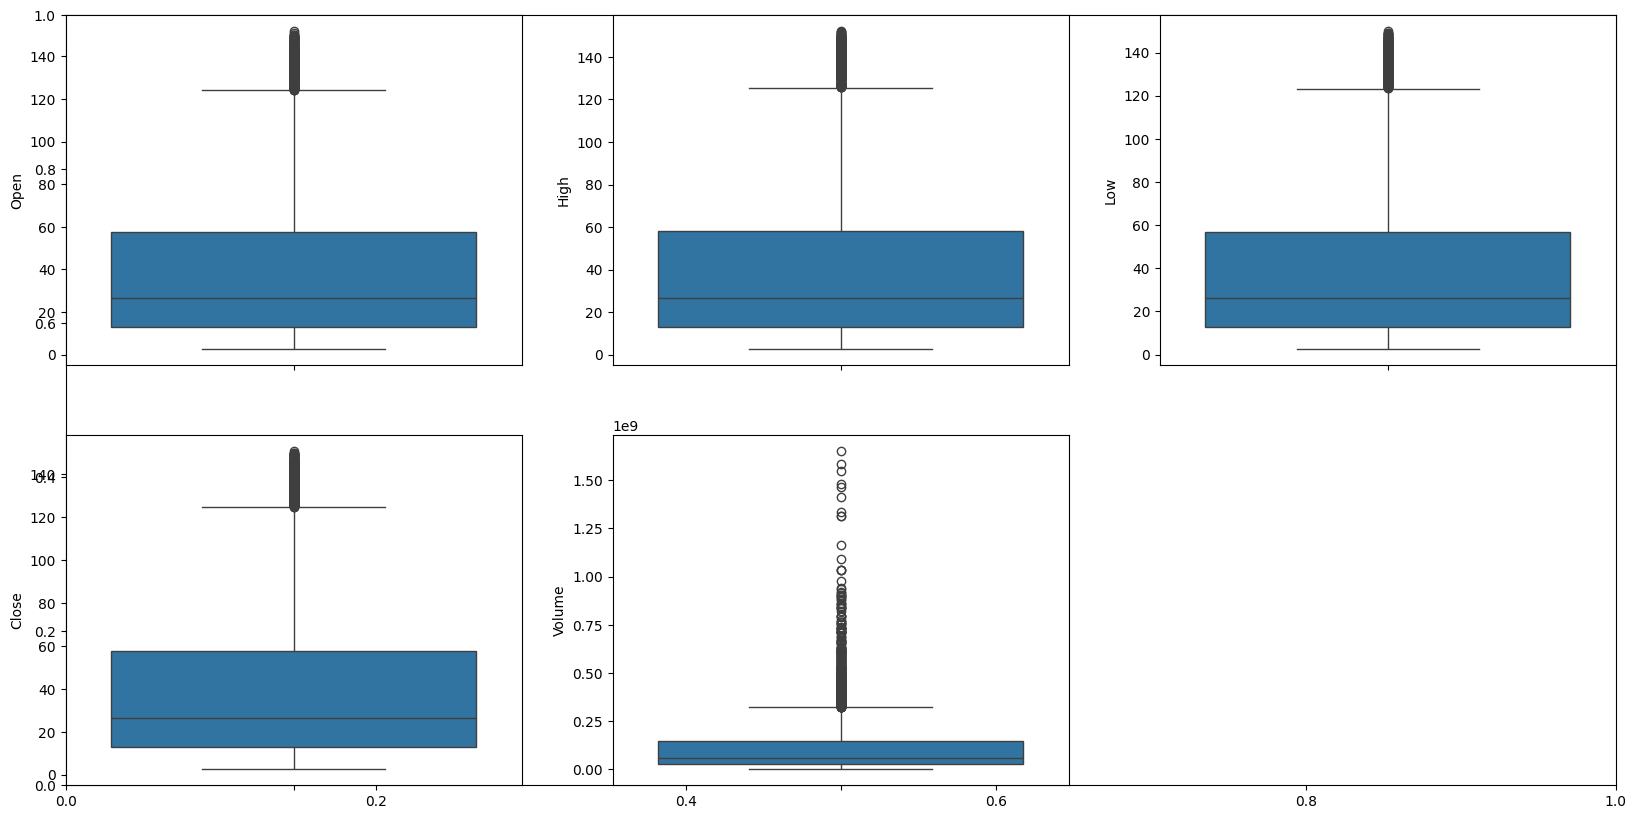

In [15]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()

In [18]:
#Creating three more columns not originally provided in dataset, derived from the Date column
splitted = df['Date'].str.split('-', expand=True)

df['year'] = splitted[0].astype(int)
df['month'] = splitted[1].astype(int)
df['day'] = splitted[2].astype(int)

df.head()

,Date,Open,High,Low,Close,Volume,year,month,day
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,897427216,2004,8,19
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,458857488,2004,8,20
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,366857939,2004,8,23
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,306396159,2004,8,24
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,184645512,2004,8,25


In [19]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end
0,2004-08-19,2.490664,2.591785,2.390042,2.499133,897427216,2004,8,19,0
1,2004-08-20,2.515820,2.716817,2.503118,2.697639,458857488,2004,8,20,0
2,2004-08-23,2.758411,2.826406,2.716070,2.724787,366857939,2004,8,23,0
3,2004-08-24,2.770615,2.779581,2.579581,2.611960,306396159,2004,8,24,0
4,2004-08-25,2.614201,2.689918,2.587302,2.640104,184645512,2004,8,25,0


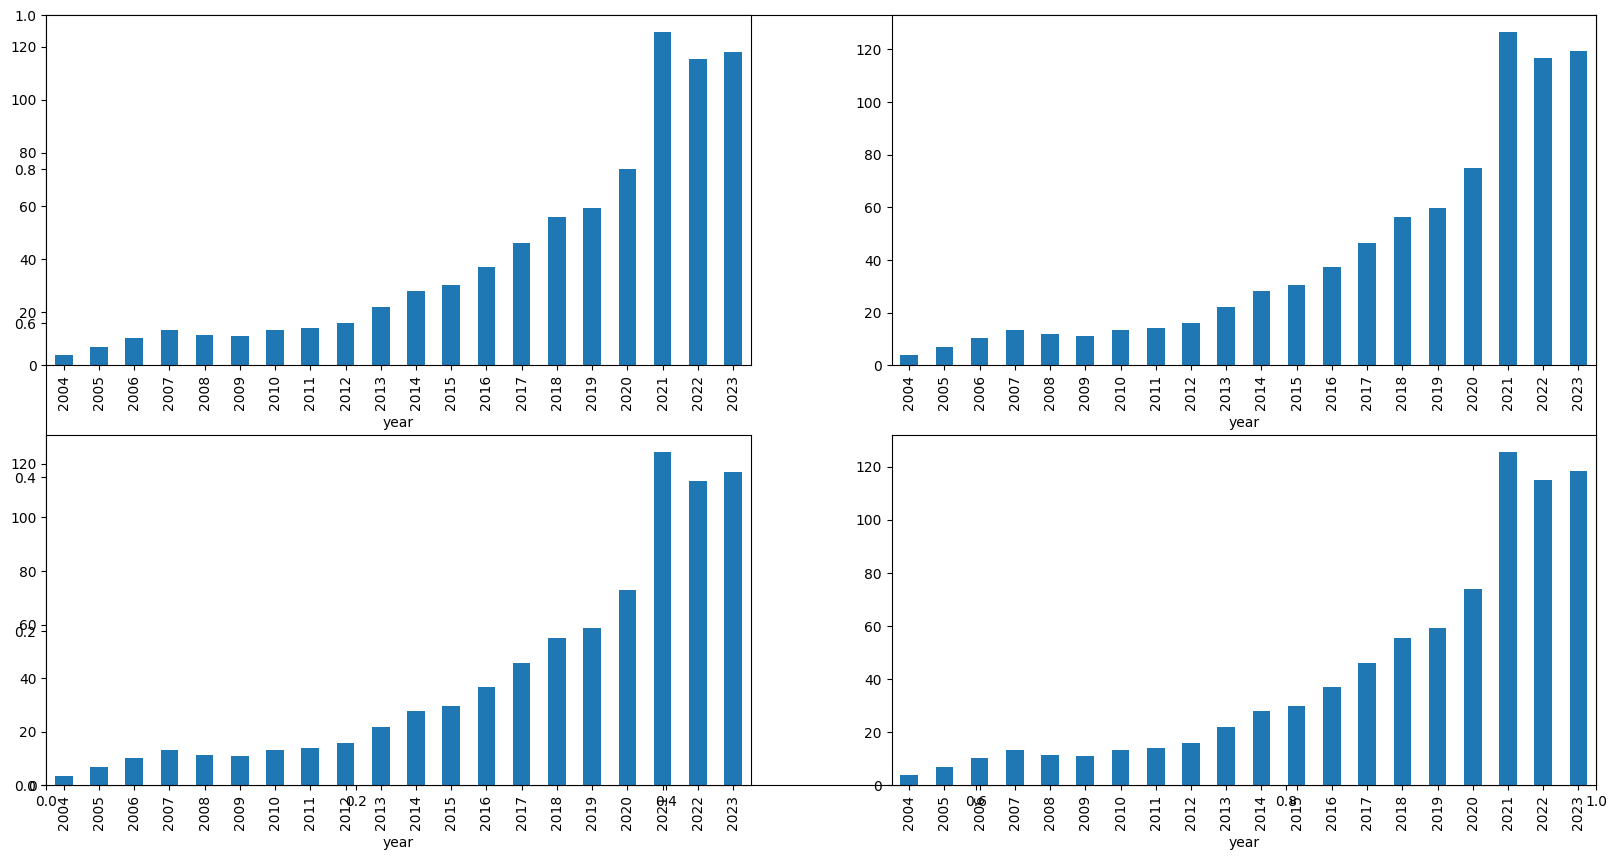

In [20]:
# Visualization by bar graph
data_grouped = df.drop('Date', axis=1).groupby('year').mean()
plt.subplots(figsize=(20,10))

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [21]:
# Data Observation - Prices are lower in the months which are quarter end as compared to that of the non-quarter end months
# Also, volume of trades is lower in months which are quarter end
df.drop('Date', axis=1).groupby('is_quarter_end').mean()

,Open,High,Low,Close,Volume,year,month,day
is_quarter_end,,,,,,,,
0,41.707116,42.161610,41.288374,41.737486,1.228721e+08,2013.836957,6.159938,15.729503
1,41.025153,41.436318,40.597686,41.016550,1.111368e+08,2013.644689,7.463370,15.771062


In [22]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

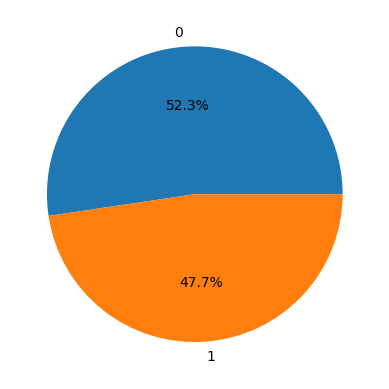

In [23]:
plt.pie(df['target'].value_counts().values,
		labels=[0, 1], autopct='%1.1f%%')
plt.show()

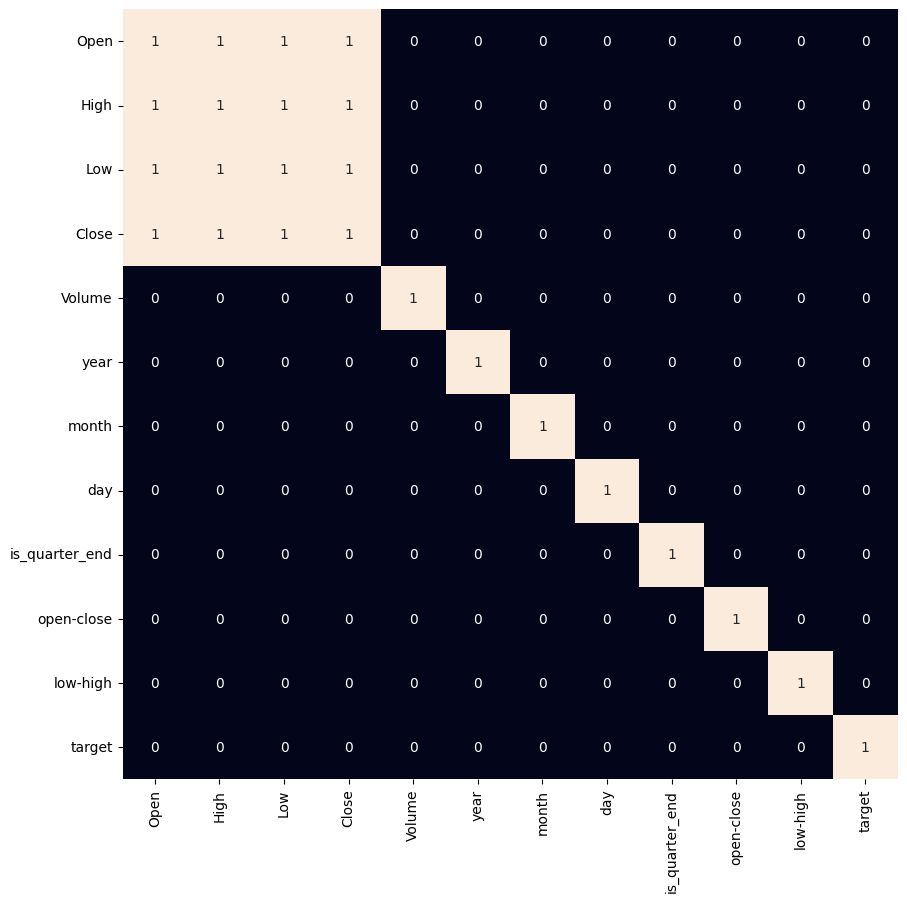

In [24]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.drop('Date', axis=1).corr() > 0.9, annot=True, cbar=False)
plt.show()

In [25]:
#Selecting features and target
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

#Splitting data into 80/20 ratio for performance evaluation
X_train, X_valid, Y_train, Y_valid = train_test_split(
	features, target, test_size=0.20, random_state=2022)
print(X_train.shape, X_valid.shape)

(3886, 3) (972, 3)


In [26]:
#Using the XGBClassifier ML model with the ROC-AUC curve evaluation metric for soft probabilities
#Of the three models used : LogisticsReg, SVC, and XGBClassifier, the results show XGBClassifier has the highest performance, but it is pruned to overfitting 
# as the differenfce between the training and the validation accuracy is too high. 
models = [LogisticRegression(), SVC(
kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5159604472862975
Validation Accuracy :  0.5008130081300812

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4881930393494501
Validation Accuracy :  0.5076431233062331

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) : 
Traini

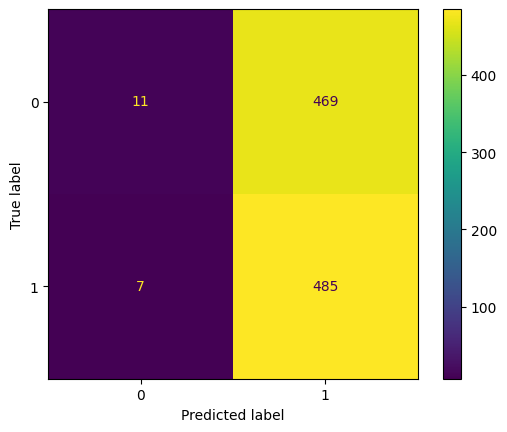

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
plt.show()